In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
import seaborn as sns

# Load metadata + hybrid vectors
df, X_hybrid = joblib.load("../data/hybrid_embeddings.pkl")

GROUP_WEIGHTS = {
    "small": 0.9,
    "medium": 1.0,
    "large": 0.75,
}

GROUP_ORDER = ["small", "medium", "large"]

In [3]:
# Base recommender: similarity only
def search_jobs_base_by_index(job_idx, top_k=100):
    q_vec = X_hybrid[job_idx]
    sims = cosine_similarity(q_vec, X_hybrid).flatten()

    ranked_idx = np.argsort(-sims)
    results = df.iloc[ranked_idx].copy()
    results["similarity"] = sims[ranked_idx]

    results = results[results.index != job_idx]

    cols = [
        "job_title",
        "company",
        "company_size_group",
        "salary_max",
        "seniority_level",
        "skills_clean",
        "similarity",
    ]
    cols = [c for c in cols if c in results.columns]
    return results[cols].head(top_k)


# Apply fairness reweighting
def reweight_fair_from_base(base_results, top_k=100):
    fair = base_results[base_results["company_size_group"] != "unknown"].copy()
    fair["fair_weight"] = fair["company_size_group"].map(
        lambda g: GROUP_WEIGHTS.get(g, 1.0)
    )
    fair["fair_score"] = fair["similarity"] * fair["fair_weight"]
    fair = fair.sort_values("fair_score", ascending=False).head(top_k)
    return fair


# Fair recommender
def search_jobs_fair_by_index(job_idx, top_k=100, candidate_k=None):
    if candidate_k is None:
        candidate_k = min(len(df) - 1, 500)
    base_results = search_jobs_base_by_index(job_idx, top_k=candidate_k)
    fair_results = reweight_fair_from_base(base_results, top_k=top_k)
    return fair_results


# Fair + Dense recommender
def search_jobs_fair_dense_by_index(
    job_idx,
    top_k=10,
    max_per_company=2,
    candidate_factor=5,
):
    candidate_k = min(len(df) - 1, top_k * candidate_factor)
    fair_candidates = search_jobs_fair_by_index(
        job_idx,
        top_k=candidate_k,
        candidate_k=candidate_k,
    )

    picked_rows = []
    per_company_count = {}

    for _, row in fair_candidates.iterrows():
        company = row.get("company", "unknown_company")
        if pd.isna(company):
            company = "unknown_company"

        if per_company_count.get(company, 0) >= max_per_company:
            continue

        picked_rows.append(row)
        per_company_count[company] = per_company_count.get(company, 0) + 1

        if len(picked_rows) >= top_k:
            break

    if not picked_rows:
        return fair_candidates.head(0)

    final = pd.DataFrame(picked_rows)
    cols = [
        "job_title",
        "company",
        "company_size_group",
        "salary_max",
        "seniority_level",
        "skills_clean",
        "similarity",
        "fair_weight",
        "fair_score",
    ]
    cols = [c for c in cols if c in final.columns]
    return final[cols]


In [4]:
# Example comparison for one seed
np.random.seed(42)
seed_idx = np.random.randint(0, len(df))

base_top10 = search_jobs_base_by_index(seed_idx, top_k=10)
fair_top10 = search_jobs_fair_by_index(seed_idx, top_k=10)
dense_top10 = search_jobs_fair_dense_by_index(seed_idx, top_k=10, max_per_company=2)

print("\n=== BASE top-10 ===")
print(base_top10.to_string(index=False))

print("\n=== FAIR top-10 ===")
print(fair_top10.to_string(index=False))

print("\n=== FAIR + DENSE top-10 ===")
print(dense_top10.to_string(index=False))


=== BASE top-10 ===
     job_title     company company_size_group  salary_max seniority_level                                                skills_clean  similarity
data scientist company_290              large     41758.0          senior             powerbi|aws|python|sql|machine learning|tableau    0.949591
data scientist company_357              large     22839.0          senior               aws|r|python|sql|gcp|machine learning|tableau    0.867780
data scientist company_251              large    156348.0          senior           aws|powerbi|r|python|sql|machine learning|tableau    0.866556
data scientist company_251              large    156350.0          senior           aws|powerbi|r|python|sql|machine learning|tableau    0.866550
data scientist company_318              large    100472.0          senior                               sql|machine learning|r|python    0.864068
data scientist company_610              large     83821.0          senior             git|r|python|sql|

In [5]:
# Dataset shares for fairness
def compute_dataset_share():
    mask = df["company_size_group"].isin(GROUP_ORDER)
    counts = df.loc[mask, "company_size_group"].value_counts().reindex(
        GROUP_ORDER, fill_value=0
    )
    return counts / counts.sum()


# Exposure share for a recommender
def compute_exposure(seeds, recommender_fn, top_k=100):
    total_counts = np.zeros(len(GROUP_ORDER), dtype=float)
    per_seed_props = []

    for job_idx in seeds:
        recs = recommender_fn(job_idx, top_k=top_k)
        recs = recs[recs["company_size_group"].isin(GROUP_ORDER)].copy()

        counts = recs["company_size_group"].value_counts().reindex(
            GROUP_ORDER, fill_value=0
        )
        total_counts += counts.values

        if counts.sum() > 0:
            per_seed_props.append((counts / counts.sum()).values)
        else:
            per_seed_props.append(np.zeros(len(GROUP_ORDER)))

    total_share = total_counts / total_counts.sum()
    per_seed_matrix = np.vstack(per_seed_props)
    return total_share, per_seed_matrix


In [6]:
# Seeds and exposure computation
raw_seeds = [0, 100, 200, 300, 400, 500, 600, 700, 800, 900]
seed_indices = [i for i in raw_seeds if i < len(df)]
top_k_exposure = 100

dataset_share = compute_dataset_share()

base_share, base_per_seed = compute_exposure(
    seed_indices,
    search_jobs_base_by_index,
    top_k=top_k_exposure,
)

fair_share, fair_per_seed = compute_exposure(
    seed_indices,
    lambda idx, top_k: search_jobs_fair_by_index(idx, top_k=top_k),
    top_k=top_k_exposure,
)

dense_share, dense_per_seed = compute_exposure(
    seed_indices,
    lambda idx, top_k: search_jobs_fair_dense_by_index(idx, top_k=top_k, max_per_company=2),
    top_k=top_k_exposure,
)


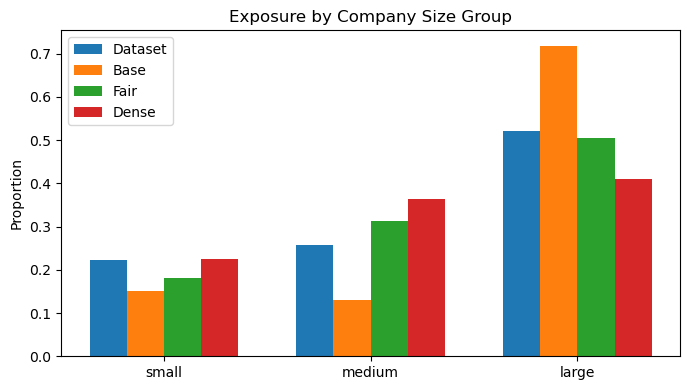

In [7]:
# Plot: dataset vs base vs fair vs dense
x = np.arange(len(GROUP_ORDER))
width = 0.18

plt.figure(figsize=(7, 4))
plt.bar(x - 1.5 * width, dataset_share.values, width, label="Dataset")
plt.bar(x - 0.5 * width, base_share,         width, label="Base")
plt.bar(x + 0.5 * width, fair_share,         width, label="Fair")
plt.bar(x + 1.5 * width, dense_share,        width, label="Dense")
plt.xticks(x, GROUP_ORDER)
plt.ylabel("Proportion")
plt.title("Exposure by Company Size Group")
plt.legend()
plt.tight_layout()
plt.show()


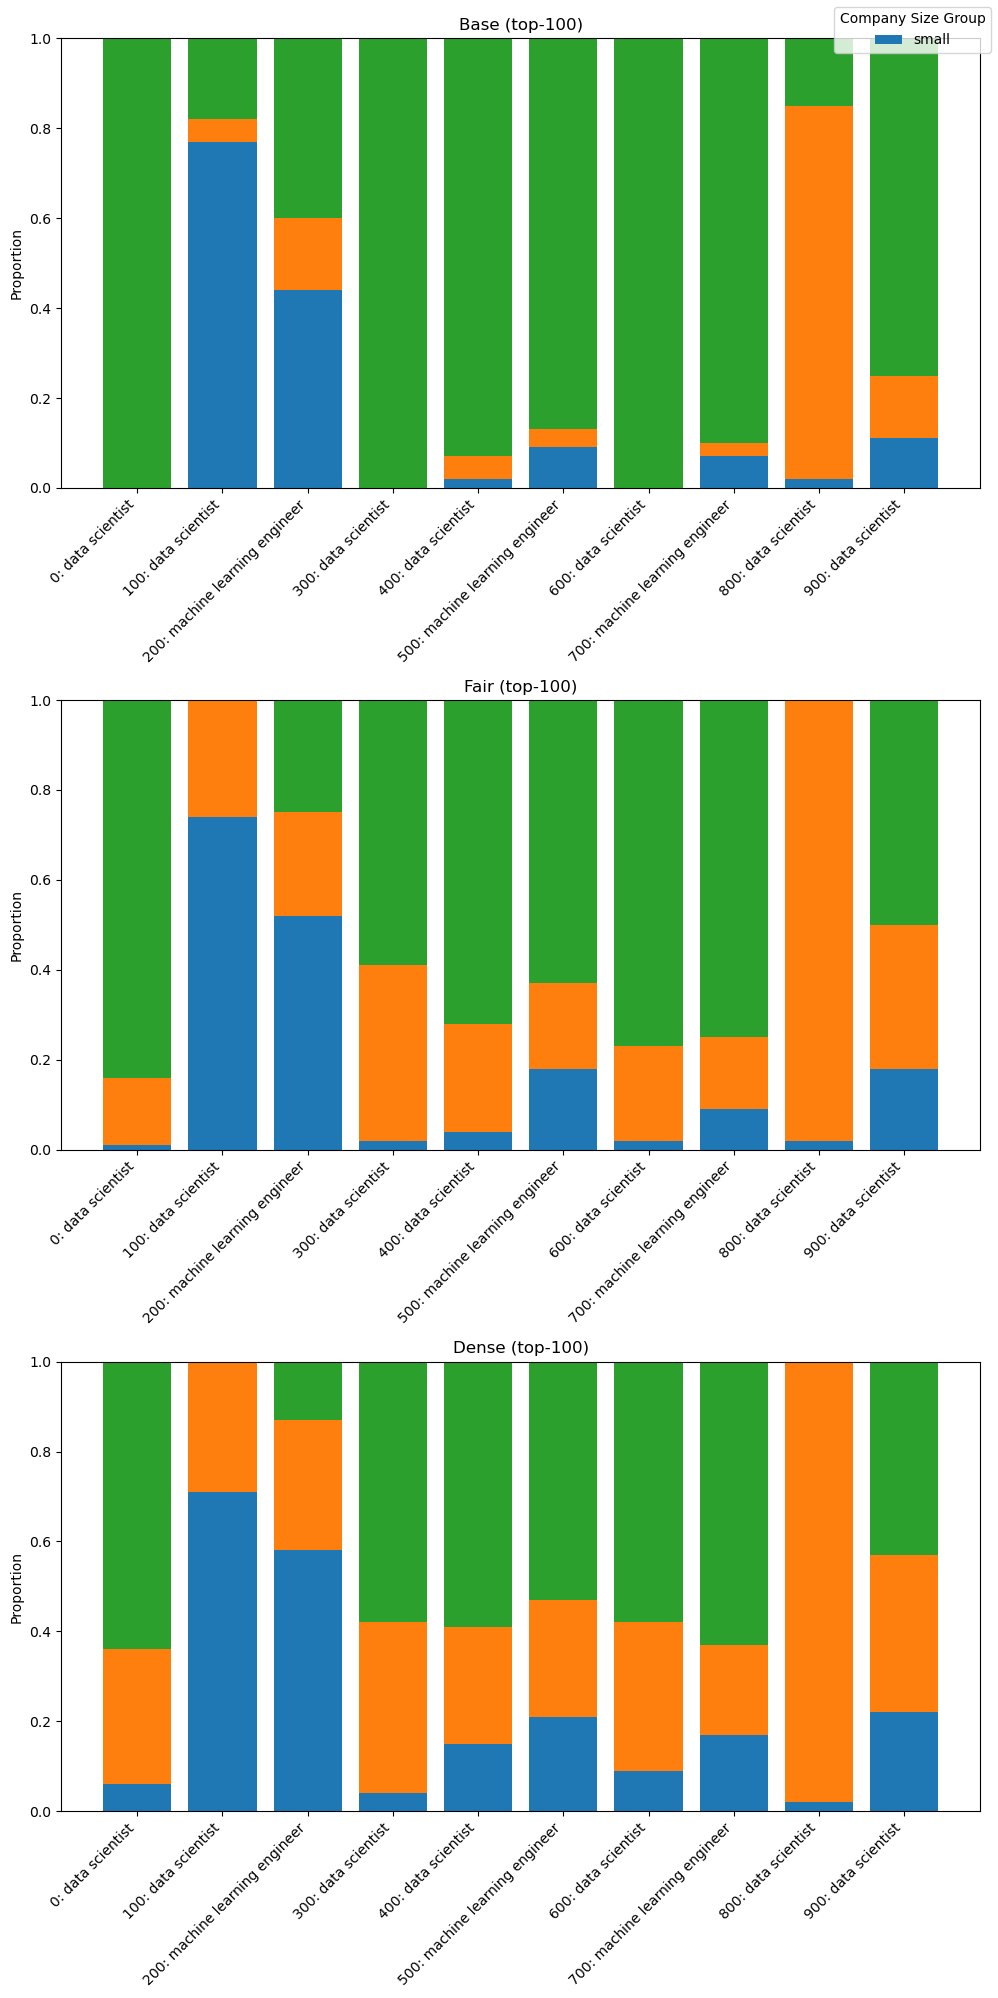

In [8]:
# Plot per-seed exposure for three recommenders
seed_labels = [f"{i}: {df.iloc[i]['job_title']}" for i in seed_indices]

fig, axes = plt.subplots(3, 1, figsize=(10, 20), sharey=True)


def plot_per_seed_stacked(ax, per_seed_matrix, title):
    bottom = np.zeros(len(seed_indices))
    for g_idx, group in enumerate(GROUP_ORDER):
        ax.bar(
            np.arange(len(seed_indices)),
            per_seed_matrix[:, g_idx],
            bottom=bottom,
            label=group if g_idx == 0 else None,
        )
        bottom += per_seed_matrix[:, g_idx]

    ax.set_title(title)
    ax.set_ylabel("Proportion")
    ax.set_xticks(np.arange(len(seed_indices)))
    ax.set_xticklabels(seed_labels, rotation=45, ha="right")


plot_per_seed_stacked(axes[0], base_per_seed, f"Base (top-{top_k_exposure})")
plot_per_seed_stacked(axes[1], fair_per_seed, f"Fair (top-{top_k_exposure})")
plot_per_seed_stacked(axes[2], dense_per_seed, f"Dense (top-{top_k_exposure})")

handles, labels = axes[2].get_legend_handles_labels()
fig.legend(handles, GROUP_ORDER, title="Company Size Group", loc="upper right")

plt.tight_layout()
plt.show()

In [9]:
def collect_recommendations(seeds, recommender_fn, top_k):
    """
    Run a recommender over all seed indices and collect a single DataFrame with:
    seed_idx, rank, company_size_group, company, ...
    """
    all_recs = []

    for job_idx in seeds:
        recs = recommender_fn(job_idx, top_k=top_k).copy()
        if recs.empty:
            continue

        recs["seed_idx"] = job_idx
        recs["rank"] = np.arange(1, len(recs) + 1)
        all_recs.append(recs)

    if not all_recs:
        return pd.DataFrame()

    return pd.concat(all_recs, ignore_index=True)


raw_seeds = [0, 100, 200, 300, 400, 500, 600, 700, 800, 900]
seed_indices = [i for i in raw_seeds if i < len(df)]
top_k_eval = 100

def compute_fairness_metrics(all_recs, name="base"):
    """
    Compute:
      - Selection Rate per group
      - Rank-aware exposure share per group
      - Proportional Fairness Error (PFE)
      - Recommendation diversity (companies)
    """
    if all_recs.empty:
        print(f"\n[{name}] No recommendations collected.")
        return None

    recs = all_recs[all_recs["company_size_group"].isin(GROUP_ORDER)].copy()

    # Selection rate
    sel_counts = (
        recs["company_size_group"]
        .value_counts()
        .reindex(GROUP_ORDER, fill_value=0)
    )
    selection_rate = sel_counts / group_counts.replace(0, np.nan)

    # Rank-aware exposure
    recs["exposure_weight"] = 1.0 / np.log2(recs["rank"] + 1.0)
    exposure_by_group = (
        recs.groupby("company_size_group")["exposure_weight"]
        .sum()
        .reindex(GROUP_ORDER, fill_value=0)
    )
    exposure_share = exposure_by_group / exposure_by_group.sum()

    # Proportional Fairness Error
    pfe = (exposure_share - dataset_share).abs().sum()

    # Diversity metrics
    total_slots = len(recs)
    distinct_companies = (
        recs["company"].nunique() if "company" in recs.columns else np.nan
    )
    diversity_ratio = (
        distinct_companies / total_slots if total_slots > 0 else np.nan
    )
    avg_companies_per_seed = (
        recs.groupby("seed_idx")["company"].nunique().mean()
        if "company" in recs.columns
        else np.nan
    )

    metrics = {
        "name": name,
        "selection_rate": selection_rate,
        "sel_counts": sel_counts,
        "exposure_share": exposure_share,
        "exposure_by_group": exposure_by_group,
        "PFE": pfe,
        "distinct_companies": distinct_companies,
        "total_slots": total_slots,
        "diversity_ratio": diversity_ratio,
        "avg_companies_per_seed": avg_companies_per_seed,
    }
    return metrics

In [10]:
base_recs = collect_recommendations(
    seed_indices, search_jobs_base_by_index, top_k_eval
)
fair_recs = collect_recommendations(
    seed_indices, search_jobs_fair_by_index, top_k_eval
)
dense_recs = collect_recommendations(
    seed_indices,
    lambda idx, top_k: search_jobs_fair_dense_by_index(
        idx,
        top_k=top_k,
        max_per_company=2,
        candidate_factor=5,
    ),
    top_k_eval,
)

group_counts = (
    df[df["company_size_group"].isin(GROUP_ORDER)]["company_size_group"]
    .value_counts()
    .reindex(GROUP_ORDER, fill_value=0)
)
dataset_share = group_counts / group_counts.sum()

# Compute metrics
base_metrics = compute_fairness_metrics(base_recs, name="Base")
fair_metrics = compute_fairness_metrics(fair_recs, name="Fair")
dense_metrics = compute_fairness_metrics(dense_recs, name="Fair+Dense")

In [11]:
def print_metrics_summary(m):
    print(f"\n===== {m['name']} Recommender =====")
    print("\nSelection counts per group:")
    print(m["sel_counts"])
    print("\nSelection Rate (SR) per group:")
    print(m["selection_rate"])
    print("\nRank-aware exposure share per group:")
    print(m["exposure_share"])
    print(f"\nProportional Fairness Error (PFE): {m['PFE']:.4f}")
    print("\nRecommendation diversity (companies):")
    print(f"  Total recommendation slots:        {m['total_slots']}")
    print(f"  Distinct companies recommended:    {m['distinct_companies']}")
    print(f"  Diversity ratio (distinct/slots):  {m['diversity_ratio']:.4f}")
    print(f"  Avg distinct companies per seed:   {m['avg_companies_per_seed']:.2f}")


print_metrics_summary(base_metrics)
print_metrics_summary(fair_metrics)
print_metrics_summary(dense_metrics)


===== Base Recommender =====

Selection counts per group:
company_size_group
small     152
medium    130
large     718
Name: count, dtype: int64

Selection Rate (SR) per group:
company_size_group
small     0.741463
medium    0.543933
large     1.492723
Name: count, dtype: float64

Rank-aware exposure share per group:
company_size_group
small     0.159465
medium    0.127154
large     0.713382
Name: exposure_weight, dtype: float64

Proportional Fairness Error (PFE): 0.3868

Recommendation diversity (companies):
  Total recommendation slots:        1000
  Distinct companies recommended:    251
  Diversity ratio (distinct/slots):  0.2510
  Avg distinct companies per seed:   51.80

===== Fair Recommender =====

Selection counts per group:
company_size_group
small     182
medium    313
large     505
Name: count, dtype: int64

Selection Rate (SR) per group:
company_size_group
small     0.887805
medium    1.309623
large     1.049896
Name: count, dtype: float64

Rank-aware exposure share per g

In [12]:
# Prepare arrays for plots
sr_base = base_metrics["selection_rate"].values
sr_fair = fair_metrics["selection_rate"].values
sr_dense = dense_metrics["selection_rate"].values

exp_base = base_metrics["exposure_share"].values
exp_fair = fair_metrics["exposure_share"].values
exp_dense = dense_metrics["exposure_share"].values

pfe_vals = [
    base_metrics["PFE"],
    fair_metrics["PFE"],
    dense_metrics["PFE"],
]

div_vals = [
    base_metrics["diversity_ratio"],
    fair_metrics["diversity_ratio"],
    dense_metrics["diversity_ratio"],
]

labels_rec = ["Base", "Fair", "Fair+Dense"]

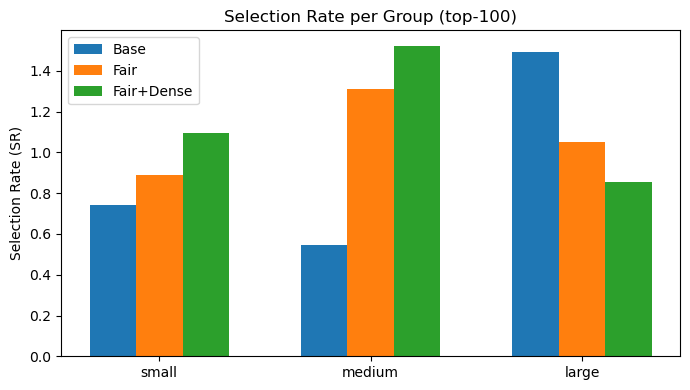

In [13]:
# Plot: Selection rate per group
x = np.arange(len(GROUP_ORDER))
width = 0.22

plt.figure(figsize=(7, 4))
plt.bar(x - width, sr_base, width, label="Base")
plt.bar(x, sr_fair, width, label="Fair")
plt.bar(x + width, sr_dense, width, label="Fair+Dense")
plt.xticks(x, GROUP_ORDER)
plt.ylabel("Selection Rate (SR)")
plt.title(f"Selection Rate per Group (top-{top_k_eval})")
plt.legend()
plt.tight_layout()
plt.show()

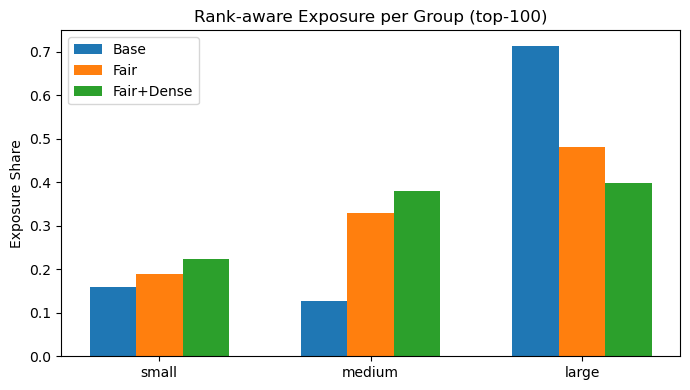

In [14]:
# Plot: Rank-aware exposure share
plt.figure(figsize=(7, 4))
plt.bar(x - width, exp_base, width, label="Base")
plt.bar(x, exp_fair, width, label="Fair")
plt.bar(x + width, exp_dense, width, label="Fair+Dense")
plt.xticks(x, GROUP_ORDER)
plt.ylabel("Exposure Share")
plt.title(f"Rank-aware Exposure per Group (top-{top_k_eval})")
plt.legend()
plt.tight_layout()
plt.show()

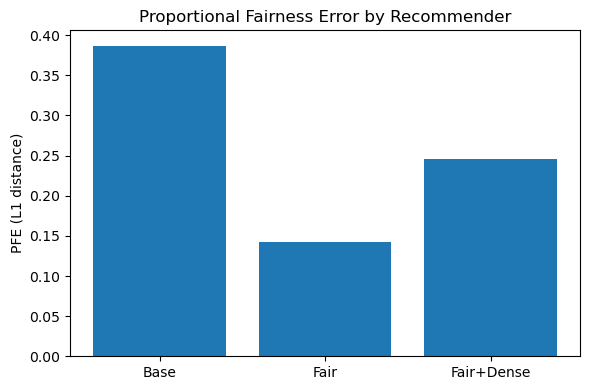

In [18]:
# Plot: PFE per recommender
plt.figure(figsize=(6, 4))
plt.bar(labels_rec, pfe_vals)
plt.ylabel("PFE (L1 distance)")
plt.title("Proportional Fairness Error by Recommender")
plt.tight_layout()
plt.show()

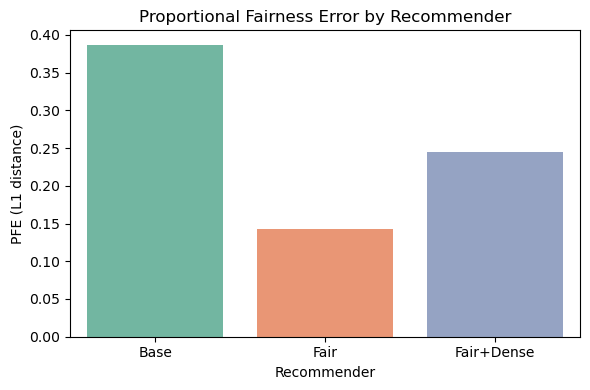

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Prepare dataframe for seaborn
df_pfe = pd.DataFrame({
    "Recommender": labels_rec,
    "PFE": pfe_vals
})

plt.figure(figsize=(6, 4))
sns.barplot(
    data=df_pfe,
    x="Recommender",
    y="PFE",
    hue="Recommender",       # <--- adds hue color
    dodge=False,             # keep single bars
    palette="Set2"           # clean pastel colors
)

plt.ylabel("PFE (L1 distance)")
plt.title("Proportional Fairness Error by Recommender")
plt.legend([],[], frameon=False)  # remove duplicated legend
plt.tight_layout()
plt.show()


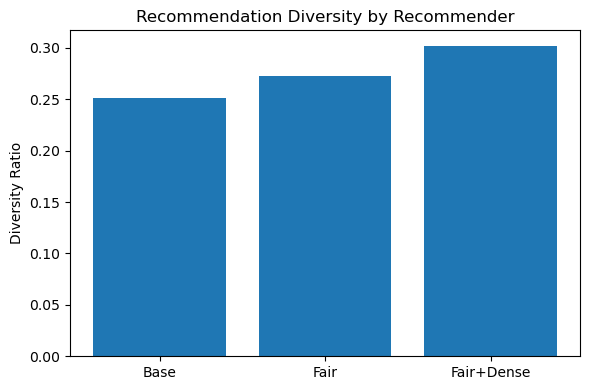

In [16]:
# Plot: Diversity ratio per recommender
plt.figure(figsize=(6, 4))
plt.bar(labels_rec, div_vals)
plt.ylabel("Diversity Ratio")
plt.title("Recommendation Diversity by Recommender")
plt.tight_layout()
plt.show()

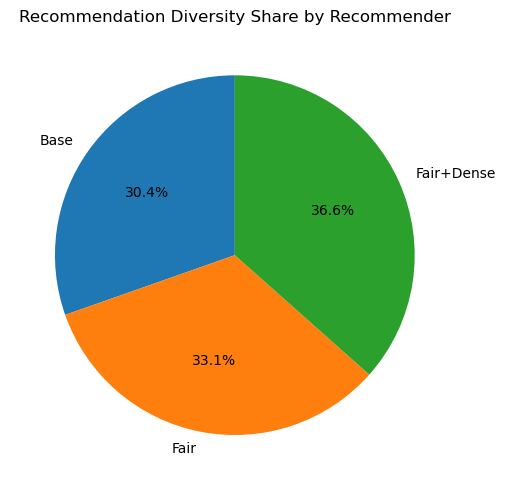

In [26]:
import matplotlib.pyplot as plt

# Use Matplotlib default color cycle (same as your company-size pie chart)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

plt.figure(figsize=(6, 5))

plt.pie(
    div_vals,
    labels=labels_rec,
    autopct="%1.1f%%",
    startangle=90,
    colors=colors[:len(div_vals)]   # match number of slices
)

plt.ylabel("")
plt.title("Recommendation Diversity Share by Recommender")
plt.tight_layout()
plt.show()


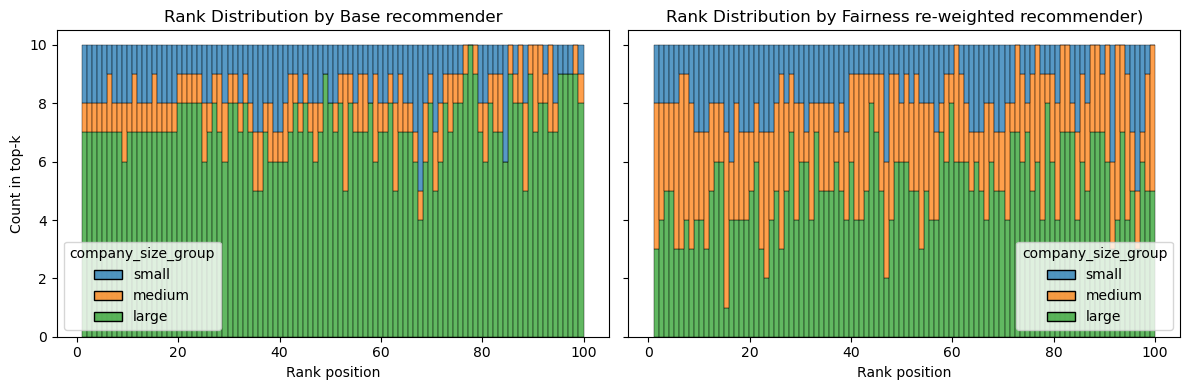

In [ ]:
def plot_rank_distribution(base_recs, fair_recs, group_order, top_k=100):
    """
    Compare how ranks are distributed across company_size_group
    for Base vs Fair recommender.
    Assumes `rank` column is 1..top_k in each recs DataFrame.
    """

    # Keep only known groups
    base_plot = base_recs[base_recs["company_size_group"].isin(group_order)].copy()
    fair_plot = fair_recs[fair_recs["company_size_group"].isin(group_order)].copy()

    # Clip ranks just in case
    base_plot["rank"] = base_plot["rank"].clip(1, top_k)
    fair_plot["rank"] = fair_plot["rank"].clip(1, top_k)

    fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

    # --- Base ---
    sns.histplot(
        data=base_plot,
        x="rank",
        hue="company_size_group",
        hue_order=group_order,
        bins=top_k,
        multiple="stack",
        ax=axes[0],
    )
    axes[0].set_title("Rank Distribution by Base recommender")
    axes[0].set_xlabel("Rank position")
    axes[0].set_ylabel("Count in top-k")

    # --- Fair ---
    sns.histplot(
        data=fair_plot,
        x="rank",
        hue="company_size_group",
        hue_order=group_order,
        bins=top_k,
        multiple="stack",
        ax=axes[1],
    )
    axes[1].set_title("Rank Distribution by Fairness re-weighted recommender")
    axes[1].set_xlabel("Rank position")
    axes[1].set_ylabel("Count in top-k")

    plt.tight_layout()
    plt.show()


plot_rank_distribution(
    base_recs=base_recs,
    fair_recs=fair_recs,
    group_order=GROUP_ORDER,
    top_k=top_k_eval,
)
